In [1]:
from astroplan import Observer,observability_table,Constraint,FixedTarget,ObservingBlock,time_grid_from_range
from astroplan.constraints import AtNightConstraint, AirmassConstraint,TimeConstraint, AltitudeConstraint
from astropy.time import TimeDelta
from astroplan import is_observable, is_always_observable,months_observable
from astroplan.plots import plot_sky

from astropy.coordinates import AltAz,SkyCoord
from astropy import units as u
from astropy.time import Time
from astropy import table

import scienceplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize


import sys
import numpy as np
from os.path import join
import os

In [113]:
def observability_table_yd(constraints, observer, targets, times=None,
                        time_range=None, time_grid_resolution=0.5*u.hour):
    """
    Creates a table with information about observability for all  the ``targets``
    over the requested ``time_range``, given the constraints in
    ``constraints_list`` for ``observer``.

    Parameters
    ----------
    constraints : list or `~astroplan.constraints.Constraint`
        Observational constraint(s)

    observer : `~astroplan.Observer`
        The observer who has constraints ``constraints``

    targets : {list, `~astropy.coordinates.SkyCoord`, `~astroplan.FixedTarget`}
        Target or list of targets

    times : `~astropy.time.Time` (optional)
        Array of times on which to test the constraint

    time_range : `~astropy.time.Time` (optional)
        Lower and upper bounds on time sequence, with spacing
        ``time_resolution``. This will be passed as the first argument into
        `~astroplan.time_grid_from_range`. If a single (scalar) time, the table
        will be for a 24 hour period centered on that time.

    time_grid_resolution : `~astropy.units.Quantity` (optional)
        If ``time_range`` is specified, determine whether constraints are met
        between test times in ``time_range`` by checking constraint at
        linearly-spaced times separated by ``time_resolution``. Default is 0.5
        hours.

    Returns
    -------
    observability_table : `~astropy.table.Table`
        A Table containing the observability information for each of the
        ``targets``. The table contains four columns with information about the
        target and it's observability: ``'target name'``, ``'ever observable'``,
        ``'always observable'``, and ``'fraction of time observable'``. The
        column ``'time observable'`` will also be present if the ``time_range``
        is given as a scalar. It also contains metadata entries ``'times'``
        (with an array of all the times), ``'observer'`` (the
        `~astroplan.Observer` object), and ``'constraints'`` (containing the
        supplied ``constraints``).
    """
    if not hasattr(constraints, '__len__'):
        constraints = [constraints]

    is_24hr_table = False
    if hasattr(time_range, 'isscalar') and time_range.isscalar:
        time_range = (time_range-12*u.hour, time_range+12*u.hour)
        is_24hr_table = True

    applied_constraints = [constraint(observer, targets, times=times,
                                      time_range=time_range,
                                      time_grid_resolution=time_grid_resolution,
                                      grid_times_targets=True)
                           for constraint in constraints]
    constraint_arr = np.logical_and.reduce(applied_constraints)

    colnames = ['target name', 'ever observable', 'always observable',
                'fraction of time observable']

    target_names = [target.name for target in targets]
    ever_obs = np.any(constraint_arr, axis=1)
    always_obs = np.all(constraint_arr, axis=1)
    frac_obs = np.sum(constraint_arr, axis=1) / constraint_arr.shape[1]

    tab = table.Table(names=colnames, data=[target_names, ever_obs, always_obs,
                                            frac_obs])

    if times is None and time_range is not None:
        times = time_grid_from_range(time_range,
                                     time_resolution=time_grid_resolution)

    if is_24hr_table:
        tab['time observable'] = tab['fraction of time observable'] * 24*u.hour

    tab.meta['times'] = times.datetime
    tab.meta['observer'] = observer
    tab.meta['constraints'] = constraints

    return tab,constraint_arr[0]

class ComplexAzimuthAltitudeConstraint(Constraint):
    def __init__(self, azimuth_ranges, altitude_constraints, boolean_constraint=True):
        """
        Initializes the constraint with specific azimuth ranges and corresponding altitude constraints.
        
        Parameters:
        -----------
        azimuth_ranges : list of tuples
            Each tuple contains two `~astropy.units.Quantity` values for the minimum and maximum azimuth.
            
        altitude_constraints : list of tuples
            Each tuple contains two `~astropy.units.Quantity` values for the minimum and maximum altitude for each azimuth range.
        """
        self.azimuth_ranges = azimuth_ranges
        self.altitude_constraints = altitude_constraints
        self.boolean_constraint = boolean_constraint

    def compute_constraint(self, times, observer, targets,time_grid_resolution=0.5*u.hour,grid_times_targets=True):
        if not isinstance(targets, (list, tuple)):
            targets = [targets]
        
        # Convert time and target to AltAz frame
        altaz = observer.altaz(times, targets)
        mask = [False] * len(times)
        if self.boolean_constraint:
            for (az_min, az_max), (alt_min, alt_max) in zip(self.azimuth_ranges, self.altitude_constraints):
                # Find targets within current azimuth range
                in_az_range = (az_min <= altaz.az) & (altaz.az <= az_max)
    
                # Apply altitude constraint within this azimuth range
                in_alt_range = (alt_min <= altaz.alt) & (altaz.alt <= alt_max)
    
                # Combine conditions
                mask = mask | (in_az_range & in_alt_range)

        return mask

## Global constraint

keckII_constraint = ComplexAzimuthAltitudeConstraint(azimuth_ranges, altitude_constraints)
obs_start = Time('2025-02-01 02:00')
obs_end = Time('2025-08-31 08:00')
timec = TimeConstraint(obs_start, obs_end)
blocks = []
observer = Observer.at_site('keck')
global_constraints = [AirmassConstraint(max = 1.5, boolean_constraint = False),
                      AltitudeConstraint(min=18.*u.deg,max=85.*u.deg), AtNightConstraint.twilight_astronomical()]



# KBSS source visibility

In [6]:
import numpy as np
import pandas as pd
fpath="/disk/bifrost/yuanze/KBSS/KCWI/z.qso.all.cat"
data = []

# Extract columns and data

obs_start = Time('2024-03-27 02:00')
obs_end = Time('2024-04-05 08:00')

with open(fpath, 'r') as f:
    for ind,line in enumerate(f):
        if not line.startswith('#'):
            if ind == 0:
                columns = line.strip().split()
            else:
            # Split only by the first 10 delimiters to keep the last column intact
                parts = line.strip().split(maxsplit=14)
                if len(parts) == 15:  # We expect 11 columns in total
                    data.append(parts)

# Convert data into DataFrame
df = pd.DataFrame(data, columns=columns)

crit= (df["R"].to_numpy(dtype=float)>22) & ((df["zlya"].to_numpy(dtype=float)>2.9) | (df["zlya"].to_numpy(dtype=float)<2.7))

filtereddf=df[crit].sort_values("RA")

In [7]:
targlist=[]

for out in filtereddf.iterrows():
    row=out[1]
    sourcename=row["Name"]
    field=row["Field"]
    psname=sourcename+"-"+field
    coordinates = SkyCoord(row["RA"],row["Dec"],unit="deg", frame='icrs')
    starg = FixedTarget(name=psname, coord=coordinates)
    targlist.append(starg)

In [10]:
ms=months_observable(global_constraints, observer, targlist, time_range=[obs_start,obs_end])
#print(psname,"is observable in month:",ms)

In [308]:
ms

[set(),
 {3, 4},
 {3, 4},
 {3, 4},
 {3, 4},
 {3, 4},
 {3, 4},
 {3, 4},
 {3, 4},
 {3, 4},
 {3, 4},
 {3, 4},
 {3, 4},
 {3, 4},
 set(),
 set(),
 set(),
 set(),
 set()]

In [311]:
mlist=["09"]
#"07","08",
for month in mlist:
    time_range = Time(['2024-{0}-01 19:00'.format(month), '2024-{0}-31 02:00'.format(month)])
    time_grid = time_grid_from_range(time_range,time_resolution=0.5*u.hour)
    ptime_grid = time_grid_from_range(time_range,time_resolution=0.5*u.hour)
    ptime_grid.format="iso"
    for nrow,out in enumerate(filtereddf.iterrows()):
        print(nrow)
        row=out[1]
        sourcename=row["Name"]
        field=row["Field"]
        psname=sourcename+"-"+field
        print("checking ",psname,"...")
        if int(month) not in ms[nrow]:
            print(month,"not in ",ms[nrow])
            continue
        coordinates = SkyCoord(row["RA"],row["Dec"],unit="deg", frame='icrs')
        starg = targlist[nrow]
        tab,con_arr=observability_table_yd(global_constraints, observer, [starg], times=time_grid)
        time_grid_cont=Time(time_grid.value[con_arr],format="jd")
        if time_grid_cont.value.size==0:
            print(psname,"not observable in ",month)
            continue
        
        fig=plt.figure(figsize=(6,6),dpi=600)
        #gs = fig.add_gridspec(1,1, hspace=0)
        ax=fig.add_subplot(projection='polar')
        
        cmap = cm.viridis             # Cycle through this colormap
        color= np.array([cmap(float(i)/len(time_grid.value)) for i in range(len(time_grid.value))])
        #for i, target in enumerate(targets):
        plot_sky(starg, observer, time_grid_cont,ax=ax,north_to_east_ccw=False,style_kwargs=dict(color=color[con_arr],label=starg.name,s=1))
        axins1 = inset_axes(ax,
                            width="5%",  # width = 50% of parent_bbox width
                            height="60%",  # height : 5%
                            loc='lower left',
                            bbox_to_anchor=(1.2,0.13,1,1),
                            bbox_transform=ax.transAxes)
        
        ## Marking keck-II unreachable angle due to Naysmith deck
        KeckIItheta=np.linspace(np.deg2rad(185.3), np.deg2rad(332.8), 100)
        ax.fill_between(KeckIItheta, 91-36.8, 91, color='red', alpha=0.3,hatch="//",label="Unreachable zone")
        
        #norm = Normalize(vmin=0, vmax=len(time_grid_cont))
        sm = plt.cm.ScalarMappable(cmap=cmap)
        pos=np.array([0,0.2,0.5,0.8,0.98])
        inds=(pos*len(time_grid)).astype(int)
        #*len(time_grid_cont.value)
        cbar=plt.colorbar(sm, ticks=pos,orientation="vertical",cax=axins1)
        cbar.ax.set_yticklabels(ptime_grid.value[inds])
        #plt.colorbar(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
        #cb.set_label('Time')
        
        legend = ax.legend(loc='upper right')
        legend.get_frame().set_facecolor('w')
        fig.savefig("/disk/bifrost/yuanze/my_work/Keck_proposal/KBSS/{0}/observability_{0}_{1}.pdf".format(month,psname))
        plt.close()

0
checking  BX58-Q0105 ...
03 not in  set()
1
checking  BX162-Q1217 ...
2
checking  BMZ1083-HDF ...
3
checking  f3388.000-HDF ...
4
checking  BX407-Q1307 ...
5
checking  DD54-GWS ...
6
checking  west2_MD13-GWS ...
7
checking  WOW-Q1422 ...
8
checking  D10-Q1549 ...
9
checking  MD28-Q1549 ...
10
checking  BX50-Q1623 ...
11
checking  MD37-Q1623 ...
12
checking  BX184-Q1623 ...
13
checking  BX367-Q1623 ...
14
checking  D9-Q0207 ...
03 not in  set()
15
checking  D1-DSF2237b ...
03 not in  set()
16
checking  MD77-Q2343 ...
03 not in  set()
17
checking  C28-Q2343 ...
03 not in  set()
18
checking  c31-Q0256 ...
03 not in  set()


In [259]:
Reachable={"Q1623":[7,8,1],"Q0105":[7,8,9,10,11,12],"Q2343":[7,8,9,10,11],"Q0256":[7,8,9,10,11,12,1],
           "DSF2237b":[7,8,9,10,11],"Q0207":[7,8,9,10,11,12],"Q1549":[7,8,1],
          "GWS":[7,12,1],"Q1422":[7,12,1],"HDF":[12,1],"Q1217":[12,1],"Q1307":[12,1]}
filtereddf['months'] = filtereddf['months'].astype(object)
for index, row in filtereddf.iterrows():
    field = row["Field"]
    # Use the DataFrame's index to properly reference the row
    filtereddf.at[index, "months"] = Reachable.get(field)


In [262]:
filtereddf

,RA,Dec,x,y,Name,Field,R,G-Rs,Un-G,Udet,zlya,zabs,zneb,Type,Comments,months
1,17.00674000,16.56680000,349.06,741.36,BX58,Q0105,23.42,0.23,0.76,yes,2.5316,2.5230,2.5351,QSO,"""msfr2, 9/13; m2+m5; zem from HeII 1640; stron...","[7, 8, 9, 10, 11, 12]"
7,184.91584000,49.66657000,535.36,1304.82,BX162,Q1217,22.62,0.03,0.61,yes,2.6347,-2.0000,-2.0000,QSO,"""""","[12, 1]"
46,189.02779600,62.26398900,2931.48,1216.16,BMZ1083,HDF,23.34,0.25,0.26,yes,2.4140,-2.0000,-1.0000,QSO,"""""","[12, 1]"
49,189.13955700,62.23821800,1993.99,1534.36,f3388.000,HDF,25.32,1.05,1.58,yes,3.4130,-2.0000,-2.0000,QSO,"""obs mosdef; (QSO)==old oC34""","[12, 1]"
8,196.95488500,29.28239000,1832.79,1042.04,BX407,Q1307,23.28,0.32,0.78,yes,2.2150,-2.0000,-1.0000,QSO,"""""","[12, 1]"
43,214.48033100,52.59244900,1781.75,4612.95,DD54,GWS,22.77,0.28,2.12,yes,3.1980,-2.0000,-1.0000,QSO,"""=west1_D1=D39 22.77 0.34 2.37 (QSO)--DLA z=2....","[7, 12, 1]"
45,214.50471500,52.49501400,1504.52,2725.62,west2_MD13,GWS,23.33,0.04,1.01,yes,2.9130,-2.0000,-1.0000,QSO,"""same as BX324; L2; =MD74 New photom. DLA z=2....","[7, 12, 1]"
12,216.16909170,22.92854030,718.02,2450.07,WOW,Q1422,22.09,1.32,5.05,no,3.6300,-2.0000,-1.0000,QSO,"""""","[7, 12, 1]"
15,237.95614000,19.17805000,733.54,726.92,D10,Q1549,23.38,0.28,2.06,yes,2.9220,-2.0000,-2.0000,QSO,"""L2; has floater on m3; strong DLA @2.842; mu...","[7, 8, 1]"
14,238.00091000,19.20514000,1191.78,1448.83,MD28,Q1549,23.42,-0.12,0.93,yes,2.5400,-2.0000,-1.0000,QSO,"""""","[7, 8, 1]"


# Multi-AGN mergers visibility

In [114]:
slist={"Mrk248":["198.822156", "44.407190"],"2MASXJ1735+2047":["263.8906493","20.79640061"],"SDSSJ0849+1114":["132.2729802","11.2466129"]}#{"IRAS03582+6012":["60.633742","60.343831"],"UGC2369NED02":["43.507504","14.970569"],"Mrk248":["198.821937","44.407105"]}
#


In [115]:

# Define azimuthal ranges and corresponding altitude constraints
azimuth_ranges = [(-27.2*u.deg, 185.3*u.deg), (185.3*u.deg, 332.8*u.deg)]
altitude_constraints = [(18.*u.deg, 85.*u.deg), (36.8*u.deg, 85.*u.deg)]

# Initialize the complex constraint




read_out = 20 * u.second
subexp = 600*u.second
#m13_exp = 100*u.second
n = 8






priority=0
bandpass="B"
#for sni, psname in enumerate(slist.keys()[0]):
#psname="IRAS03582+6012"
psname="Mrk248"
coordinates = SkyCoord(slist[psname][0],slist[psname][1],unit="deg", frame='icrs')
starg = FixedTarget(name=psname, coord=coordinates)
# We want each filter to have separate priority (so that target
# and reference are both scheduled)
b = ObservingBlock.from_exposures(starg, priority, subexp, n, read_out,
                                    configuration = {'filter': bandpass},
                                    constraints = [timec])
blocks.append(b)
print(coordinates.to_string(style='hmsdms'))

13h15m17.31744s +44d24m25.884s


In [116]:
targlist=[]

for psname in slist.keys():
    out=slist[psname]
    coordinates = SkyCoord(out[0],out[1],unit="deg", frame='icrs')
    starg = FixedTarget(name=psname, coord=coordinates)
    targlist.append(starg)

In [117]:
ms=months_observable(global_constraints, observer, targlist, time_range=[obs_start,obs_end])

In [118]:
ms

[{2, 3, 4, 5, 6, 7}, {2, 3, 4, 5, 6, 7, 8}, {2, 3, 4, 5}]

In [127]:

mlist=["02","03","04","05","06","07","08"]
#"07","08",
for month in mlist:
    time_range = Time(['2024-{0}-25 02:00'.format(month), '2024-{0}-29 02:00'.format(month)])
    time_grid = time_grid_from_range(time_range,time_resolution=0.5*u.hour)
    ptime_grid = time_grid_from_range(time_range,time_resolution=0.5*u.hour)
    ptime_grid.format="iso"
    for nrow,psname in enumerate(slist.keys()):
        #print(nrow)
        row=slist[psname]
        #sourcename=row["Name"]
        #field=row["Field"]
        #psname=sourcename+"-"+field
        print("checking ",psname,"...")
        if int(month) not in ms[nrow]:
            print(month,"not in ",ms[nrow])
            continue
        coordinates = SkyCoord(row[0],row[1],unit="deg", frame='icrs')
        starg = targlist[nrow]
        tab,con_arr=observability_table_yd(global_constraints, observer, [starg], times=time_grid)
        time_grid_cont=Time(time_grid.value[con_arr],format="jd")
        if time_grid_cont.value.size==0:
            print(psname,"not observable in ",month)
            continue
        
        fig=plt.figure(figsize=(6,6),dpi=600)
        #gs = fig.add_gridspec(1,1, hspace=0)
        ax=fig.add_subplot(projection='polar')
        
        cmap = cm.viridis             # Cycle through this colormap
        color= np.array([cmap(float(i)/len(time_grid.value)) for i in range(len(time_grid.value))])
        #for i, target in enumerate(targets):
        plot_sky(starg, observer, time_grid_cont,ax=ax,north_to_east_ccw=False,style_kwargs=dict(color=color[con_arr],label=starg.name,s=1))
        axins1 = inset_axes(ax,
                            width="5%",  # width = 50% of parent_bbox width
                            height="60%",  # height : 5%
                            loc='lower left',
                            bbox_to_anchor=(1.2,0.13,1,1),
                            bbox_transform=ax.transAxes)
        
        ## Marking keck-II unreachable angle due to Naysmith deck
        KeckIItheta=np.linspace(np.deg2rad(185.3), np.deg2rad(332.8), 100)
        ax.fill_between(KeckIItheta, 91-36.8, 91, color='red', alpha=0.3,hatch="//",label="Unreachable zone")
        
        #norm = Normalize(vmin=0, vmax=len(time_grid_cont))
        sm = plt.cm.ScalarMappable(cmap=cmap)
        pos=np.array([0,0.2,0.5,0.8,0.98])
        inds=(pos*len(time_grid)).astype(int)
        #*len(time_grid_cont.value)
        cbar=plt.colorbar(sm, ticks=pos,orientation="vertical",cax=axins1)
        cbar.ax.set_yticklabels(ptime_grid.value[inds])
        #plt.colorbar(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
        #cb.set_label('Time')
        
        legend = ax.legend(loc='upper right')
        legend.get_frame().set_facecolor('w')
        try:
            os.mkdir("/disk/bifrost/yuanze/my_work/Keck_proposal/multiAGN/{0}".format(month))
        except:
            print("Directory existed")
        fig.savefig("/disk/bifrost/yuanze/my_work/Keck_proposal/multiAGN/{0}/observability_{0}_{1}.pdf".format(month,psname))
        plt.close()


checking  Mrk248 ...
Directory existed
checking  2MASXJ1735+2047 ...
Directory existed
checking  SDSSJ0849+1114 ...
Directory existed
checking  Mrk248 ...
Directory existed
checking  2MASXJ1735+2047 ...
Directory existed
checking  SDSSJ0849+1114 ...
Directory existed
checking  Mrk248 ...
Directory existed
checking  2MASXJ1735+2047 ...
Directory existed
checking  SDSSJ0849+1114 ...
Directory existed
checking  Mrk248 ...
Directory existed
checking  2MASXJ1735+2047 ...
Directory existed
checking  SDSSJ0849+1114 ...
SDSSJ0849+1114 not observable in  05
checking  Mrk248 ...
Directory existed
checking  2MASXJ1735+2047 ...
Directory existed
checking  SDSSJ0849+1114 ...
06 not in  {2, 3, 4, 5}
checking  Mrk248 ...
Directory existed
checking  2MASXJ1735+2047 ...
Directory existed
checking  SDSSJ0849+1114 ...
07 not in  {2, 3, 4, 5}
checking  Mrk248 ...
08 not in  {2, 3, 4, 5, 6, 7}
checking  2MASXJ1735+2047 ...
Directory existed
checking  SDSSJ0849+1114 ...
08 not in  {2, 3, 4, 5}


In [299]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":7,
"legend.fancybox":True})

time_range = Time(['2024-03-28 02:00', '2024-03-30 02:00'])
time_grid = time_grid_from_range(time_range,time_resolution=0.5*u.hour)

tab,con_arr=observability_table_yd(global_constraints, observer, targ, times=time_grid)

time_grid_cont=Time(time_grid.value[con_arr],format="jd")



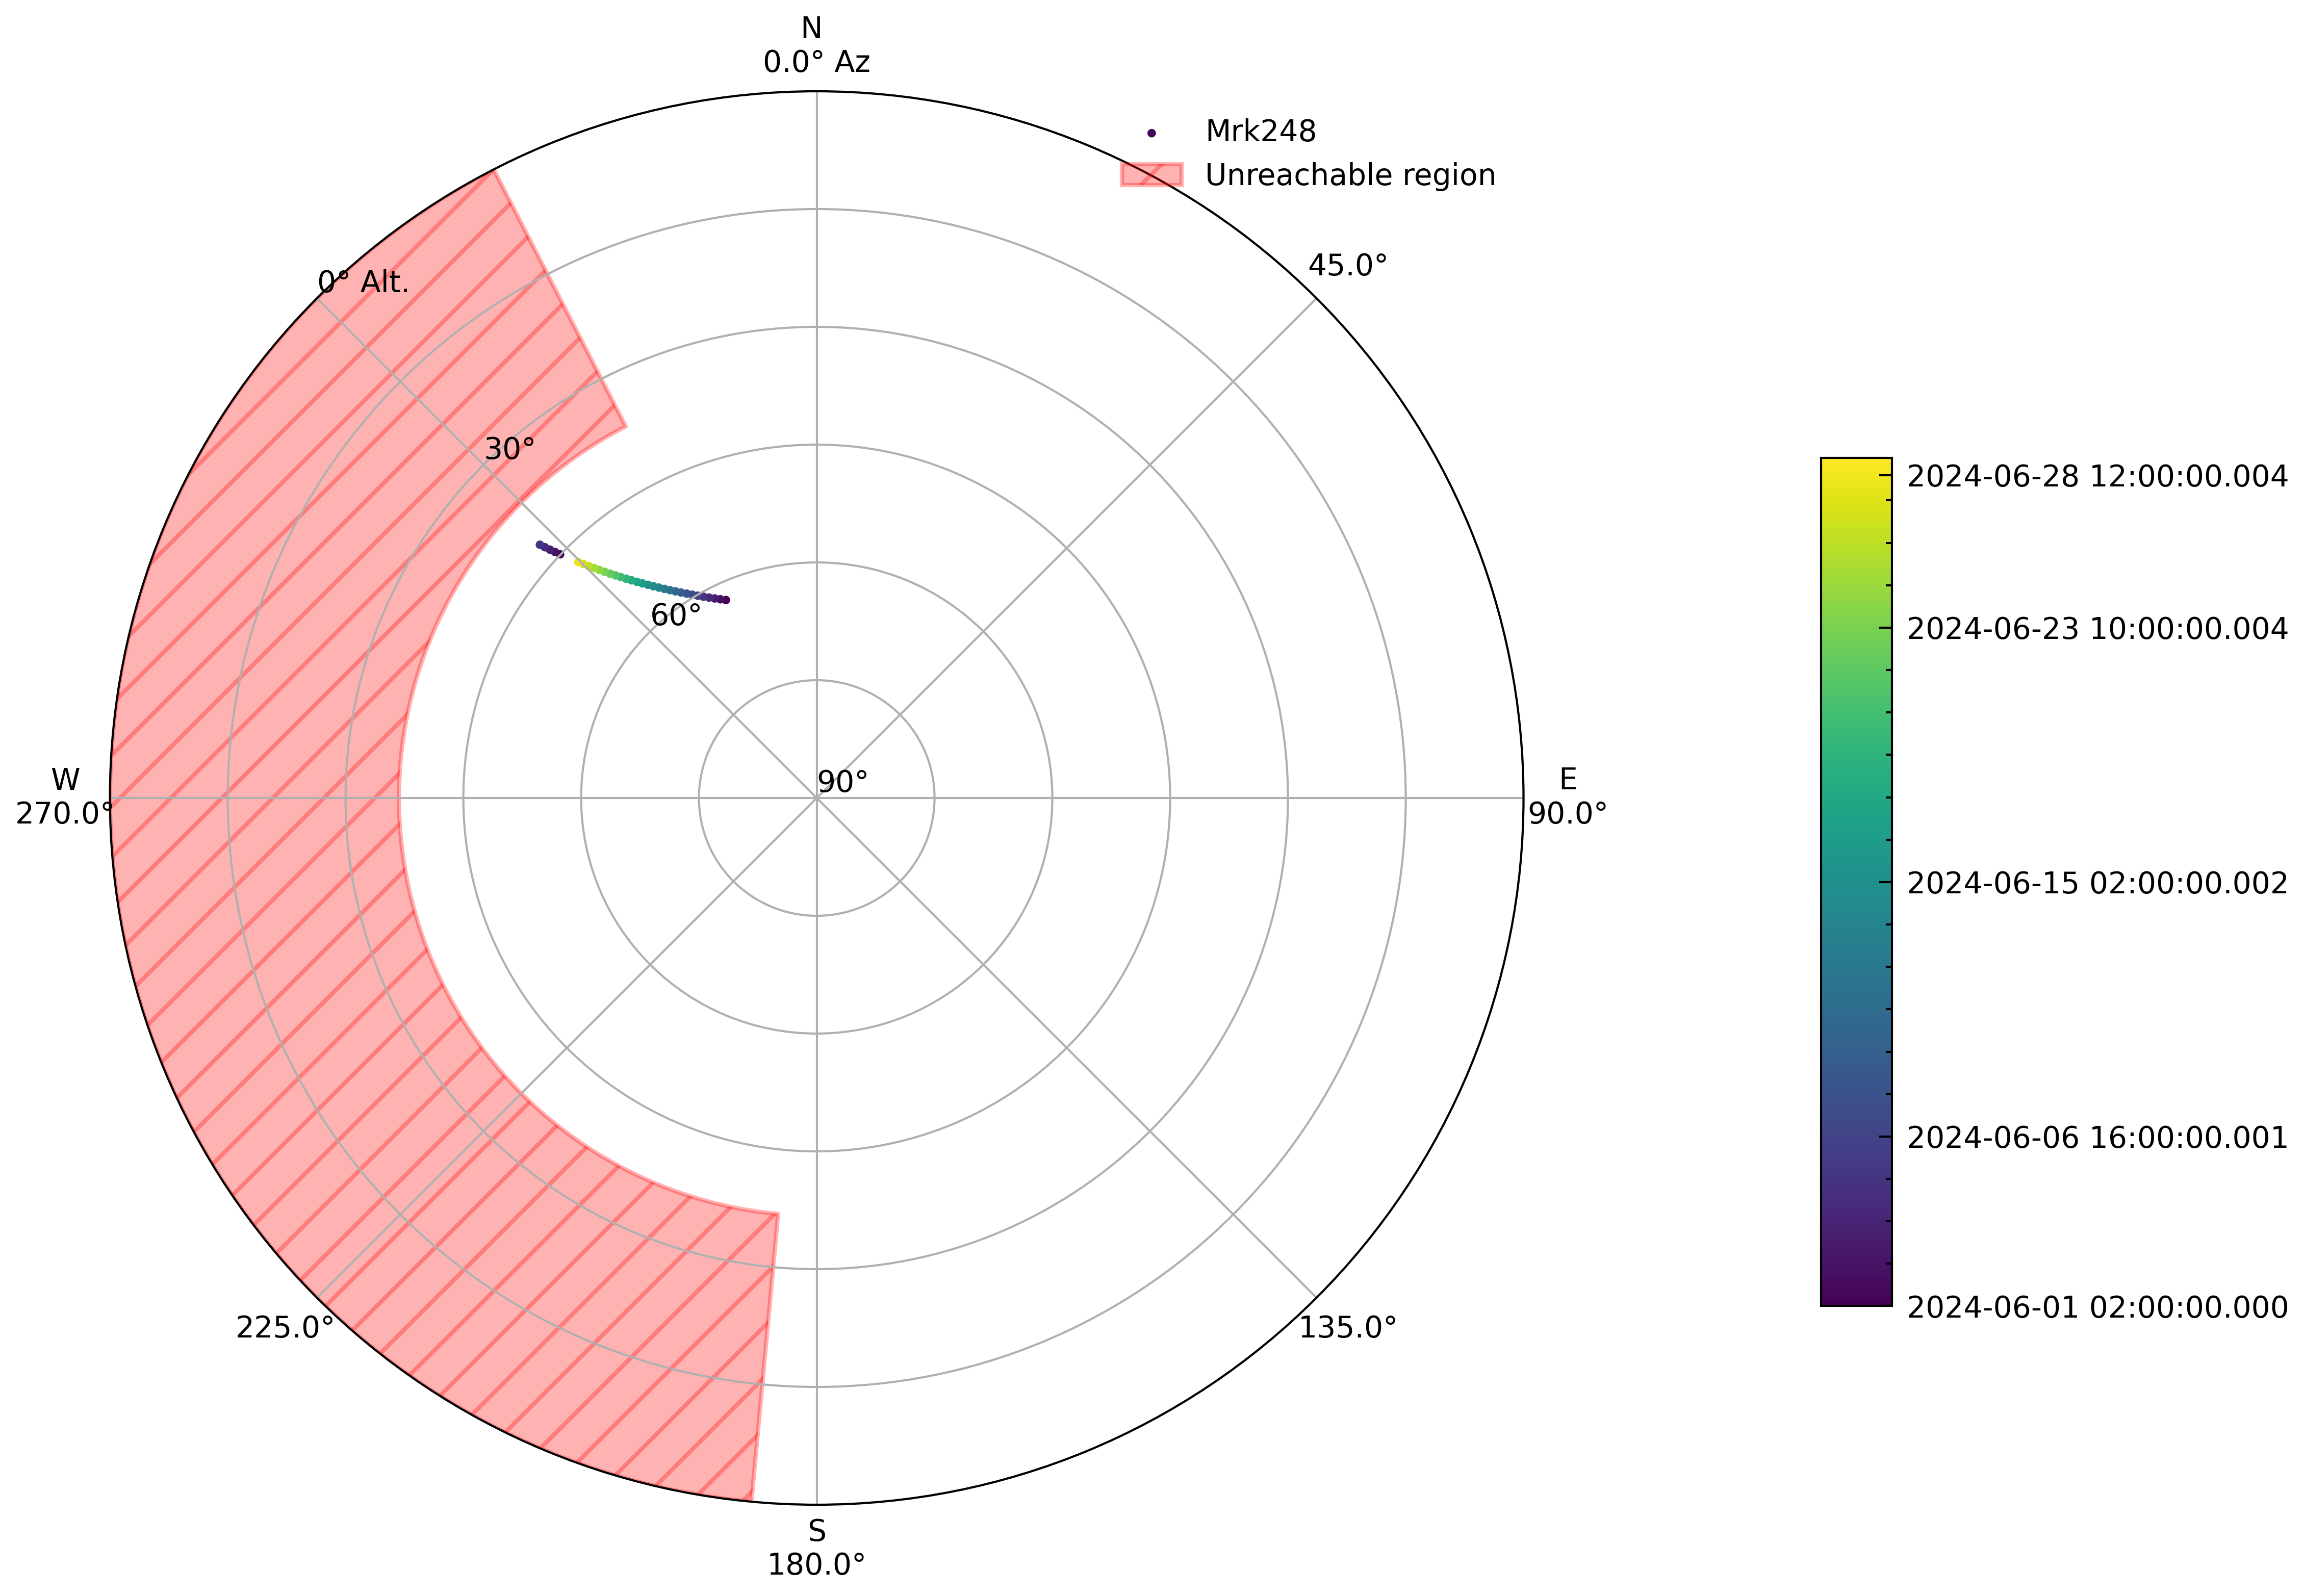

In [300]:
fig=plt.figure(figsize=(6,6),dpi=600)
#gs = fig.add_gridspec(1,1, hspace=0)
ax=fig.add_subplot(projection='polar')

cmap = cm.viridis             # Cycle through this colormap
color= np.array([cmap(float(i)/len(time_grid.value)) for i in range(len(time_grid.value))])
#for i, target in enumerate(targets):
plot_sky(starg, observer, time_grid_cont,ax=ax,north_to_east_ccw=False,style_kwargs=dict(color=color[con_arr],label=starg.name,s=1))
axins1 = inset_axes(ax,
                    width="5%",  # width = 50% of parent_bbox width
                    height="60%",  # height : 5%
                    loc='lower left',
                    bbox_to_anchor=(1.2,0.13,1,1),
                    bbox_transform=ax.transAxes)

## Marking keck-II unreachable angle due to Naysmith deck
KeckIItheta=np.linspace(np.deg2rad(185.3), np.deg2rad(332.8), 100)
ax.fill_between(KeckIItheta, 91-36.8, 91, color='red', alpha=0.3,hatch="//",label="Unreachable region")

#norm = Normalize(vmin=0, vmax=len(time_grid_cont))
sm = plt.cm.ScalarMappable(cmap=cmap)
pos=np.array([0,0.2,0.5,0.8,0.98])
inds=(pos*len(time_grid)).astype(int)
#*len(time_grid_cont.value)
cbar=plt.colorbar(sm, ticks=pos,orientation="vertical",cax=axins1)
time_grid.format="iso"
cbar.ax.set_yticklabels(time_grid.value[inds])
#plt.colorbar(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
#cb.set_label('Time')

legend = ax.legend(loc='upper right')
legend.get_frame().set_facecolor('w')
fig.savefig("/disk/bifrost/yuanze/my_work/Keck_proposal/multiAGN/observability_{}.pdf".format(psname))

In [65]:
observability = observability_table(global_constraints, observer, [starg], time_range=obs_end)

In [21]:
from astroplan.scheduling import Transitioner

# Initialize a transitioner object with the slew rate and/or the
# duration of other transitions (e.g. filter changes)
slew_rate = .8*u.deg/u.second
transitioner = Transitioner(slew_rate,
                            {'filter':{('B','G'): 10*u.second,
                                       ('G','R'): 10*u.second,
                                       'default': 30*u.second}})

In [22]:
from astroplan.scheduling import Schedule
from astroplan.scheduling import SequentialScheduler

seq_scheduler = SequentialScheduler(constraints = global_constraints,
                                    observer = observer,
                                    transitioner = transitioner)
# Initialize a Schedule object, to contain the new schedule
sequential_schedule = Schedule(obs_start, obs_end)

# Call the schedule with the observing blocks and schedule to schedule the blocks
seq_scheduler(blocks, sequential_schedule)

Schedule containing 1 observing blocks between 2024-07-01 02:00:00.000 and 2025-01-31 08:00:00.000

In [167]:
pxs=8.09600000000E-05*3600
pxp=0.00018859*3600
print(pxs,pxp)
print("arcsec^2/pixel:",pxs*pxp)
rbin=np.logspace(-0.5,0.48,num=6)

0.291456 0.6789240000000001
arcsec^2/pixel: 0.19787647334400002


In [161]:
from astropy import constants
lflux=4e-18 #erg/s/cm^2
wline=4500*u.AA
sigma_v=200*u.km/u.s #km/s
sigma_w=sigma_v*wline/(constants.c.to(u.km/u.s)-sigma_v)

lsflux=lflux/sigma_w*0.3989 # gaussian peak specific flux
mag=-2.5*np.log10(wline.value**2/constants.c.to(u.AA/u.s).value*lsflux.value)-48.6
print(mag)
print(sigma_w)

25.01295820257301
3.004080963880606 Angstrom


In [174]:
lflux=1e-18 #erg/s/cm^2
wline=4012*u.AA # Lya at z=2.3
sigma_v=200*u.km/u.s #km/s
sigma_w=sigma_v*wline/(constants.c.to(u.km/u.s)-sigma_v)

#S=np.pi*3.**2
S=np.pi*(rbin[2]**2-rbin[1]**2)
lsflux=lflux/sigma_w*0.3989 # gaussian peak specific flux
mag=-2.5*np.log10(wline.value**2/constants.c.to(u.AA/u.s).value*lsflux.value)-48.6
magpas=-2.5*np.log10(wline.value**2/constants.c.to(u.AA/u.s).value*lsflux.value/S)-48.6
print(mag)
print(sigma_w)
print("mag/arcsec",magpas)
print("SB:",lflux/S)

26.642737154460328
2.6783050726864426 Angstrom
mag/arcsec 26.780975895168886
SB: 8.804496065476196e-19


In [158]:
lsflux.value/pxs*pxp

2.3121494839805726e-18

Q0207 32.439 -0.1307
Coord: 265.956 15.178
Coord: 32.439 -0.1307
20.203333333333333


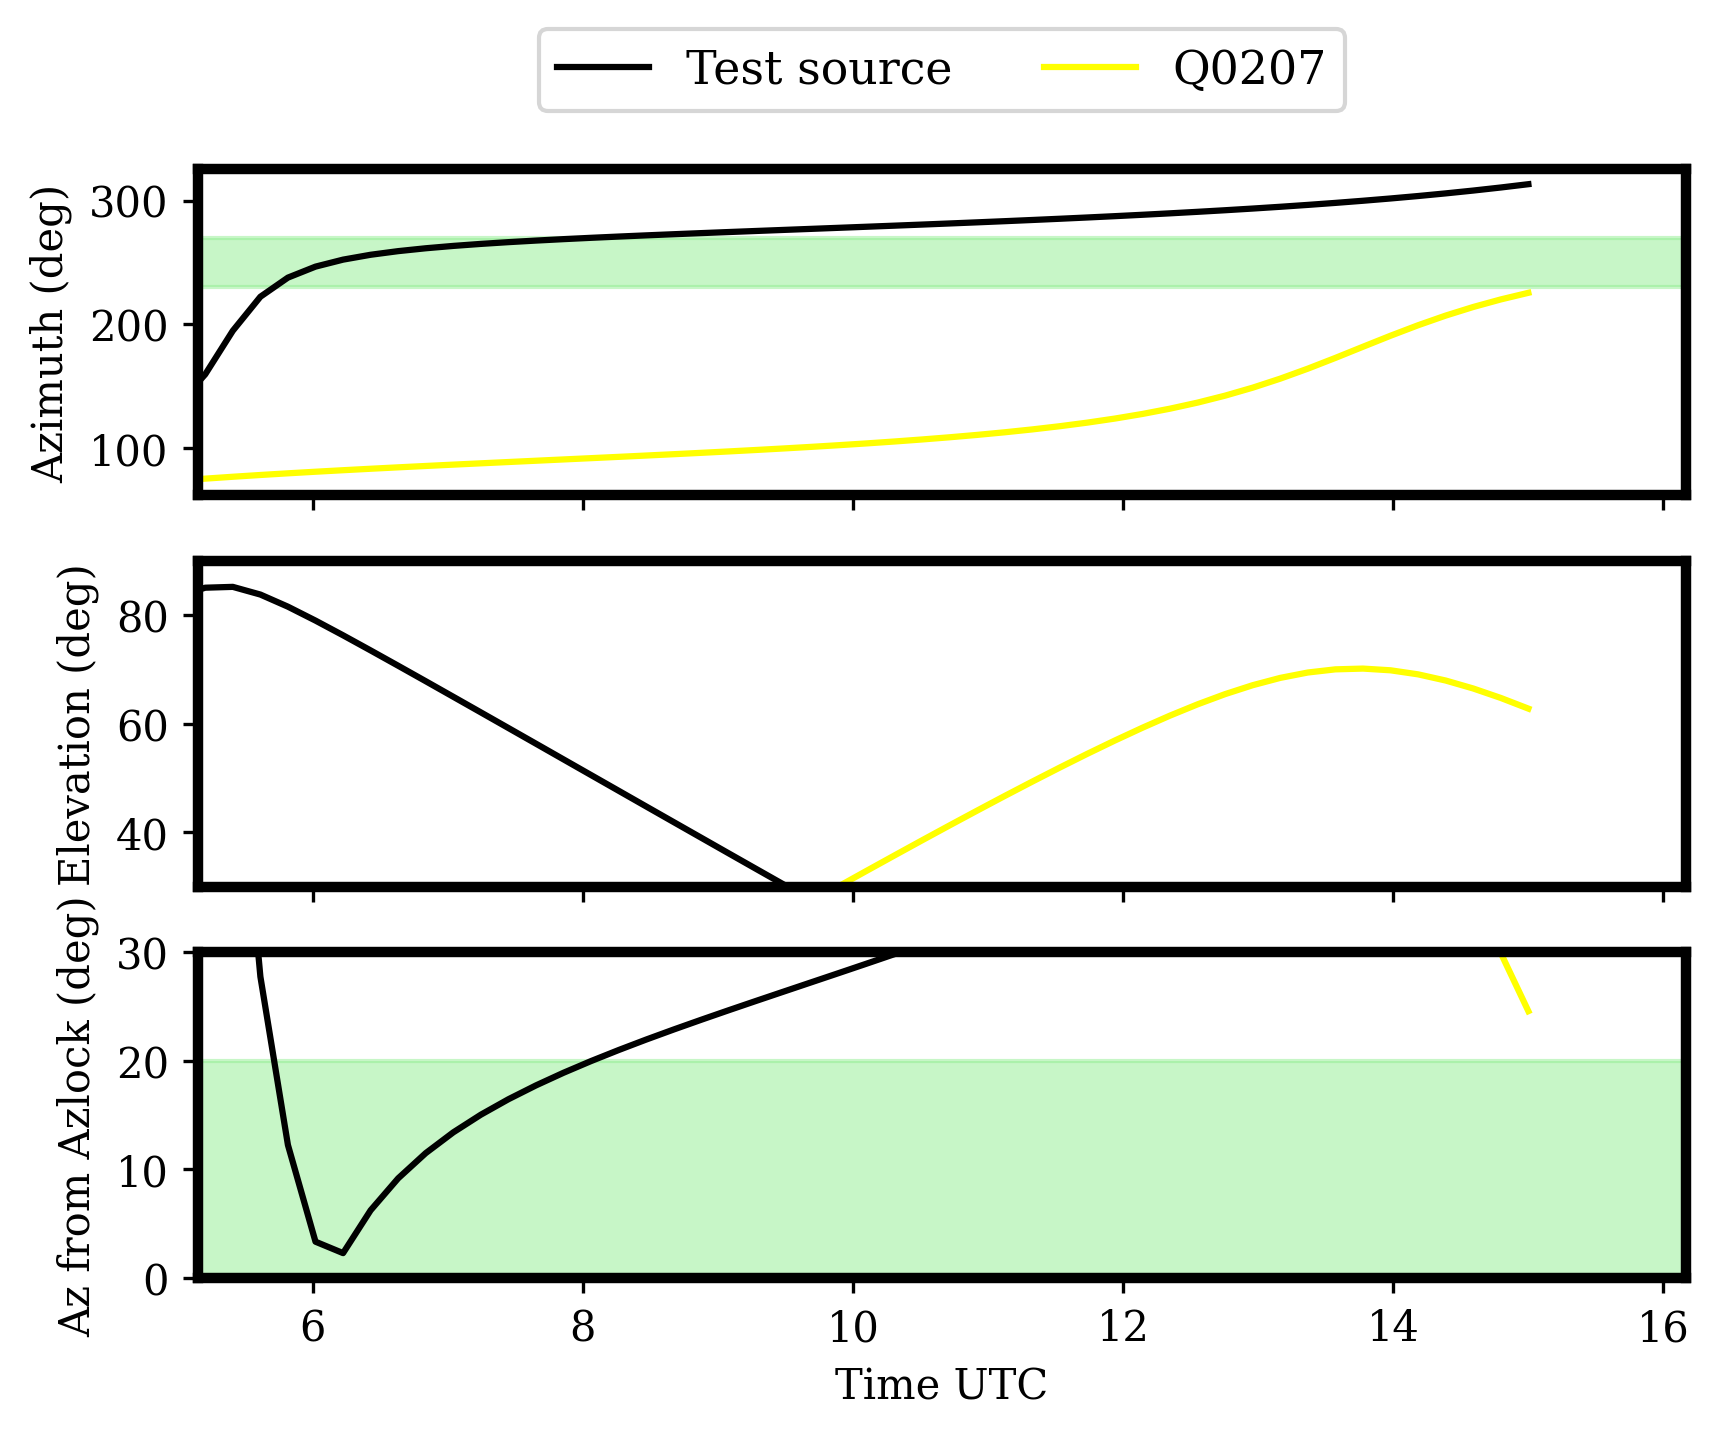

In [89]:
from astropy.time import Time
from astropy.coordinates import EarthLocation
from astropy.coordinates import SkyCoord
import astroplan
from astroplan.plots import plot_airmass, plot_altitude
from astroplan import Observer
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
import astropy.units as u
import numpy as np
from matplotlib import pyplot as plt

import re

azlock=250

#ralist=[334.2881,17.00674,356.508,44.741,339.089,339.875,46.126,246.381]#[79.5,140.94,166.418,171.10,174.787]
#declist=[0.2965,16.566,12.807,0.212,13.958,11.789,-0.136,26.827]#[-9.568,16.547,25.4078,24.975,31.119]
ralist=[265.956]
declist=[15.178]
name=["Test source"]
#col=['b','c','g','k','m']
#Q0207 32.439 -0.1307
#name=["LyC22","Q0105","Q2343","Q0256","Q2233","DSF2237","Q0302","Q1623"]
with open('snt.list') as f:
    for line in f:
        print(line)
        _name,_ra,_dec=re.split(' ',line)
        name.append(_name)
        ralist.append(float(_ra))
        declist.append(float(_dec))
#col=list(map('C{}'.format,(range(len(name)))))
col = iter(plt.cm.gnuplot(np.linspace(0, 1, len(ralist))))

keck = EarthLocation(lat=19.828333333333333*u.deg, lon=-155.47833333333335*u.deg, height=4160.000000000756*u.m)
start_time = Time('2024-09-02 05:00:00')
#all_times = start_time + np.linspace(0, 11, 100) * u.hour

plt.rc('axes', lw = 2.5); plt.rc('font', family = 'serif')

fig,ax=plt.subplots(nrows=3, ncols=1, sharex=True,dpi=300)
ax[0].axhspan(azlock-20, azlock+20, alpha=0.5, color='lightgreen')
ax[2].axhspan(0, 20, alpha=0.5, color='lightgreen')

for idx in range(len(ralist)):
    c=next(col)
    print('Coord:',ralist[idx],declist[idx])
    target = SkyCoord(ra=ralist[idx]*u.degree, dec=declist[idx]*u.degree, frame='icrs')
    all_times = start_time + np.linspace(0, 10, 50) * u.hour

    hours,h,s = [],[],[]
    alts = []
    azs = []
    t=0
    for i, time in enumerate(all_times):
        sep=[]
        t_altaz = target.transform_to(AltAz(obstime=time,location=keck))
        coord = SkyCoord(alt = t_altaz.alt, az = t_altaz.az, frame='altaz',location=keck)
        coord2 = SkyCoord(alt = np.arange(30,89.5,0.5)*u.deg, az = azlock*u.deg, frame='altaz',location=keck)
        #[sep.append(c) for c in coord.separation(coord2).deg]
        #s.append(np.min(sep))
        s.append(np.abs(azlock-coord.az.deg))
        alts.append(t_altaz.alt / u.degree)
        azs.append(t_altaz.az / u.degree)

        hour = time.datetime.hour
        minute = time.datetime.minute
        second = time.datetime.second
        hours.append(hour + minute / 60.0 + second / 3600.0)
        h.append(hour + minute / 60.0 + second / 3600.0)
        if t!=0:
            if abs(azs[t-1]-azs[t])>300:
                ax[0].plot(hours[:-1],azs[:-1],color=c)
                ax[1].plot(hours[:-1],alts[:-1],color=c)
                _azs=azs[t]
                _alts=alts[t]
                _hours=hours[t]
                azs=[]
                azs.append(_azs)
                alts=[]
                alts.append(_alts)
                hours=[]
                hours.append(_hours)
                t=0
        t=t+1
    ax[2].plot(h,s,color=c,label=name[idx])
    ax[0].plot(hours,azs,color=c,label=name[idx])
    ax[1].plot(hours,alts,color=c)
ax[2].set(xlabel='Time UTC')
ax[0].set_xlim(5+0/60,16+3/60);ax[1].set_xlim(5+0/60,16+3/60); ax[2].set_xlim(5+0/60,16+3/60)
ax[0].set(ylabel='Azimuth (deg)')
#ax[1].set(xlabel='Time UTC')
ax[1].set(ylabel='Elevation (deg)')
ax[1].set_ylim([30, 90])
ax[2].set(ylabel='Az from Azlock (deg)')
ax[2].set_ylim([0,30])
ax[0].set_xlim(5+9/60, 15+10/60); ax[1].set_xlim(5+9/60, 15+10/60);  ax[2].set_xlim(5+9/60, 16+10/60)
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
          ncol=7, fontsize = 11)
#plt.show()

from datetime import datetime, timezone
timenow  = datetime.now(timezone.utc).hour + datetime.now(timezone.utc).minute/60 + datetime.now(timezone.utc).minute/3600
print(timenow)
#ax[2].axvline(timenow, label = 'NOW', color = 'black',lw=2)
#ax[1].axvline(timenow, label = 'NOW', color = 'black',lw=2)
#ax[0].axvline(timenow, label = 'NOW', color = 'black',lw=2)

225.43846386140729

In [46]:
coord.separation(SkyCoord(alt = 83.6*u.deg, az = azlock*u.deg, frame='altaz',location=keck)).deg

9.438428123930711

In [49]:
coord

<SkyCoord (AltAz: obstime=None, location=(-5464487.81759887, -2492806.59108569, 2151240.19451846) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (154.33581881, 83.65390616)>

In [44]:
SkyCoord(alt = 85.0*u.deg, az = azlock*u.deg, frame='altaz',location=keck)

<SkyCoord (AltAz: obstime=None, location=(-5464487.81759887, -2492806.59108569, 2151240.19451846) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (250., 85.)>

In [52]:
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

# Assuming Keck Observatory location
keck = EarthLocation.of_site('Keck Observatory')

# Define azlock and create SkyCoord objects
azlock = 250.0  # degrees
coord1 = SkyCoord(alt=83.65390616*u.deg, az=azlock*u.deg, frame='altaz', location=keck)
coord2 = SkyCoord(alt=83.65390616*u.deg, az=154.33581881*u.deg, frame='altaz', location=keck)

# Calculate the angular separation
separation = coord1.separation(coord2)

print(f"The angular separation is {separation.deg} degrees")

The angular separation is 9.398515597513809 degrees
